This script intends to provide a quick and basic example of a credit analysis framework. We will be exploring a dataset from ICE indices (C0A0) that represents US Investment Grade Corporate Credit. Our intent is to identify bonds in the Tech industry with a BBB-B rating that have strong credit quality and trade at an attractive level. ICE data was collected on 7/29/2023 and company financials are downloaded upon executing this script.

The credit quality evaluation will utilize the Altman Z-score, a common framework that has been popularized in academia. The analysis of value will be conducted using the Nelson-Siegel model to fit a curve to the OAS of all bonds within the desired sample. From there, we will calculate the residual of each bond to the implied OAS generated from the fitted curve and will average each issuer's distance to the curve. This value will represent the average value embedded into the bonds of the issuer.

In [25]:
import pandas as pd
df = pd.read_excel('C:/Users/dstoc/Documents/Python Scripts/First Project/ICE Agg.xlsx')
df2 = df.copy()

df2 = df2.iloc[0:len(df2),]
df2.head(10)

,Ticker,Cusip,Description,Par Wtd Coupon,Maturity Date,Industry Lvl 3 Code,Industry Lvl 4 Code,Rating,OAS,Effective Duration,Total Return % 6-mo_LOC,Total Return % 3-mo_LOC,Total Return % 1-mo_LOC,Spread to Worst,Yield to Maturity (s.a.),Yield to Worst (conv.),Yield to Maturity (conv.),Yield to Worst (s.a.),Effective Yield,% Mkt Value
0,A,00846UAK,Agilent Technologies Inc.,3.050,2026-09-22,Hcar,HDev,BBB1,116,3.01,1.259,0.992,-1.902,119,5.46,5.46,5.46,5.46,5.43,0.003668
1,A,00846UAL,Agilent Technologies Inc.,2.750,2029-09-15,Hcar,HDev,BBB1,122,5.53,2.315,1.954,-2.470,122,5.12,5.12,5.12,5.12,5.11,0.005758
2,A,00846UAM,Agilent Technologies Inc.,2.100,2030-06-04,Hcar,HDev,BBB1,142,6.18,1.955,1.285,-2.652,141,5.28,5.28,5.28,5.28,5.28,0.005409
3,A,00846UAN,Agilent Technologies Inc.,2.300,2031-03-12,Hcar,HDev,BBB1,140,6.79,1.622,0.904,-2.958,139,5.23,5.23,5.23,5.23,5.23,0.009121
4,AA,013822AE,Alcoa Nederland Holding B.V.,5.500,2027-12-15,Basc,Metl,BBB3,134,2.69,4.443,1.868,-0.530,210,6.17,6.17,6.17,6.17,5.42,0.009812
5,AA,013822AC,Alcoa Nederland Holding B.V.,6.125,2028-05-15,Basc,Metl,BBB3,145,2.69,4.580,1.947,-0.413,240,6.42,6.42,6.42,6.42,5.49,0.006485
6,AA,013822AG,Alcoa Nederland Holding B.V.,4.125,2029-03-31,Basc,Metl,BBB3,207,4.46,5.016,2.416,-0.554,227,6.20,6.20,6.20,6.20,6.01,0.005935
7,AALLN,034863AS,Anglo American Capital PLC,3.625,2024-09-11,Basc,Metl,BBB1,108,1.22,2.488,1.305,-0.329,108,6.10,6.10,6.10,6.10,6.10,0.008324
8,AALLN,034863AP,Anglo American Capital PLC,4.875,2025-05-14,Basc,Metl,BBB1,121,1.83,2.881,1.497,-0.535,121,5.89,5.89,5.89,5.89,5.89,0.004364
9,AALLN,034863AR,Anglo American Capital PLC,4.750,2027-04-10,Basc,Metl,BBB1,152,3.43,3.761,0.821,-1.286,152,5.69,5.69,5.69,5.69,5.69,0.008932


## Define a few functions to convert the maturity dates to a numeric value and then another to apply the custom valuation methodology.

In [26]:
from datetime import datetime, timedelta

# Define the date format
date_format = "%Y-%m-%dT%H:%M:%S.%f"

# Define a function to convert a date string to the number of days away
def convert_to_years(date_str):
    #date_obj = datetime.strptime(date_str, date_format)
    date_obj = date_str#.strftime("%Y-%m-%d")
    current_date = datetime.now()
    years_away = (date_obj - current_date).days / 365

    if years_away < 0:
        years_away = years_away + 100  # Add 100 years (365.25 days per year on average)
    
    return years_away

# Apply the function to the 'Date' column
df2['MaturityYears'] = df2['Maturity Date'].apply(convert_to_years)


In [27]:
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, errorfn_ns_ols
from matplotlib import pyplot as plt

def my_NS_func(x_df):
    time = np.array(x_df["MaturityYears"])
    yld = np.array(x_df["OAS"])


    curve, status = calibrate_ns_ols(
        time,yld, tau0= 0.10
    )  
    assert status.success
    curve  

    Yhat = x_df['OAS'].apply(curve)
    x_df.loc[:,'Yhat'] = Yhat

    Spread_to_Curve = x_df['OAS'] - x_df['Yhat']
    return Spread_to_Curve

In [28]:
df3 = df2.copy()
df3['OAS'] = df3['OAS'].astype(float)
df3 = df3.dropna(subset='OAS')
df3 = df3[df3['Industry Lvl 3 Code'] == 'Tech']
df3 = df3[df3['Rating'].isin(['BBB1','BBB2','BBB3'])]

In [29]:
df3['OAS'].isna().any()

False

## Plot the term structure of the desired industry.

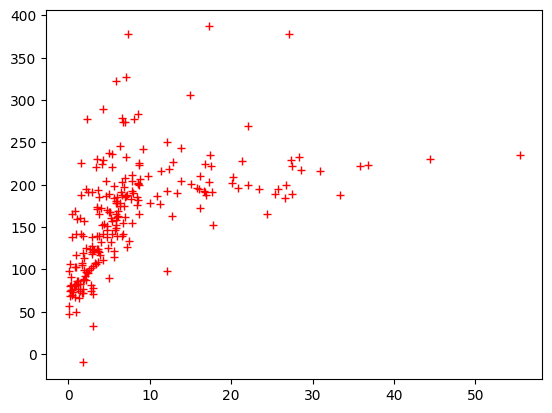

In [30]:
time = np.array(df3["MaturityYears"])
yld = np.array(df3["OAS"])
plt.plot(time,yld, "r+"); 


## Fit a Nelson-Siegel Model to the data

In [31]:
curve, status = calibrate_ns_ols(
    time,yld, tau0=0.1
)  
assert status.success
curve  

NelsonSiegelCurve(beta0=237.03899173871037, beta1=-149.18309531535968, beta2=-180.29871163602786, tau=1.0407397491476509)

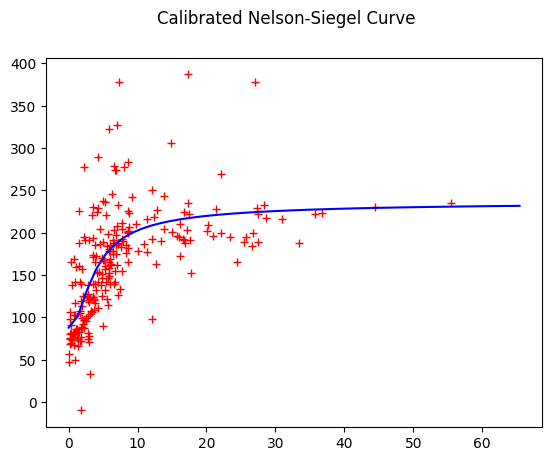

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Calibrated Nelson-Siegel Curve")
ax.plot(time, yld, "r+")
t2 = np.linspace(0, df3['MaturityYears'].max() +10 )
ax.plot(t2, curve(t2), "b-");

## Generate implied OAS values from the model and calculate residuals. Since we are only using one sector, the function we defined earlier is not necessary.

In [33]:
df3['Yhat'] = df3['MaturityYears'].apply(curve)
df3['Spread to Curve'] = df3['OAS'] - df3['Yhat']

## Copy the dataframe and average the residuals by each issuer

In [34]:
df4 = df3.copy()
df4['Issuer Avg Spread to Curve'] = df4.groupby('Ticker')['Spread to Curve'].transform('mean')

## We now proceed to evaluating the credit quality of our companies. This will be done using Yahoo Finance as it is freely available data. Unfortunately, not every issuer has data available so our pool shrinks a bit.

In [35]:
import yfinance as yf
import pandas as pd

## Define and apply functions to pull data and calcualte desired metrics

In [36]:
def get_financial_ratios(ticker):
    # Get financial data using yfinance
    company = yf.Ticker(ticker)
    financials = company.quarterly_financials
    bal_sht = company.quarterly_balance_sheet
    inc_stmt = company.quarterly_income_stmt
    cash_flw_stmt = company.quarterly_cash_flow

    # Calculate relevant financial ratios
    debt_to_equity = bal_sht.loc["Total Debt"][0] / bal_sht.loc["Stockholders Equity"][0]
    interest_coverage = inc_stmt.loc["Operating Income"][0] / inc_stmt.loc["Interest Expense"][0]

    # Altman Z-score components
    working_capital = bal_sht.loc["Current Assets"][0] - bal_sht.loc["Current Liabilities"][0]
    retained_earnings = bal_sht.loc["Retained Earnings"][0]
    EBIT = inc_stmt.loc["Total Operating Income As Reported"][0]
    total_assets = bal_sht.loc["Total Assets"][0]
    total_equity = bal_sht.loc["Stockholders Equity"][0]
    total_liabilities = total_assets - total_equity

    z_score = 1.2 * (working_capital / total_assets) + 1.4 * (retained_earnings / total_assets) + \
               3.3 * (EBIT / total_assets) + 0.6 * (total_equity / total_assets) + 1.0 * (total_liabilities / total_assets)

    # Create a dictionary with the results
    ratios = {
        "Debt-to-Equity Ratio": debt_to_equity,
        "Interest Coverage Ratio": interest_coverage,
        "Altman Z-Score": z_score,
    }

    return ratios


In [37]:
def evaluate_companies(tickers):
    results = []
    for ticker in tickers:
        try:
            ratios = get_financial_ratios(ticker)
            results.append(pd.DataFrame([ratios], index=[ticker]))
        except Exception as e:
            print(f"Error evaluating {ticker}: {e}")

    # Merge all dataframes into a single dataframe
    merged_df = pd.concat(results)
    return merged_df


In [38]:

if __name__ == "__main__":
    # List of company tickers you want to evaluate
    #company_tickers = ["AAPL", "MSFT", "GOOGL", "META", "ORCL"]
    company_tickers = df4['Ticker'].unique()

    # Evaluate companies and get the results as a dataframe
    credit_quality_df = evaluate_companies(company_tickers)
    print(credit_quality_df)


Error evaluating DXC: 'Total Operating Income As Reported'
Error evaluating GIBACN: 'Total Debt'
Error evaluating HYUELE: 'Total Debt'
Error evaluating KD: 'Total Operating Income As Reported'
Error evaluating LENOVO: 'Total Debt'
Error evaluating LWSN: 'Total Debt'
Error evaluating MOLX: 'Total Debt'
Error evaluating NECELE: 'Total Debt'
Error evaluating NOKIA: 'Total Debt'
Error evaluating OTEXCN: 'Total Debt'
Error evaluating SUMDIG: 'Total Debt'
Error evaluating VMW: 'Total Debt'
Error evaluating XIAOMI: 'Total Debt'
      Debt-to-Equity Ratio  Interest Coverage Ratio  Altman Z-Score
ADSK              1.786775                      NaN             NaN
APH               0.496389                17.973753        1.703152
AVGO              1.057961                 3.110793        0.931267
BAH               3.475319                 5.445145        1.773311
DELL            -10.812812                 3.997319        0.809274
DOX               0.226633                16.213906        2.4075

In [39]:
credit_quality_df.reset_index(inplace=True)
credit_quality_df = credit_quality_df.rename(columns = {'index':'Ticker'})

In [40]:
credit_quality_df2 = credit_quality_df.copy()
credit_quality_df2 = credit_quality_df2.iloc[:,0:4]

## Gather the valuation for each of the remaining companies and add it to the dataframe

In [41]:
credit_quality_df2["Issuer Avg Spread to Curve"] = np.nan

In [42]:
for ticker in credit_quality_df2['Ticker']:
    temp_df = df4[df4['Ticker'] == ticker]
    credit_quality_df2.loc[credit_quality_df2['Ticker'] == ticker, 'Issuer Avg Spread to Curve'] = temp_df['Issuer Avg Spread to Curve'].iloc[0]

In [43]:
from itables import init_notebook_mode


data = credit_quality_df2.copy()
data2 = pd.DataFrame(data)

data2


,Ticker,Debt-to-Equity Ratio,Interest Coverage Ratio,Altman Z-Score,Issuer Avg Spread to Curve
0,ADSK,1.786775,NaN,NaN,-55.720235
1,APH,0.496389,17.973753,1.703152,-50.752500
2,AVGO,1.057961,3.110793,0.931267,-9.251255
3,BAH,3.475319,5.445145,1.773311,66.315931
4,DELL,-10.812812,3.997319,0.809274,-5.070978
5,DOX,0.226633,16.213906,2.407547,-2.342620
6,FLEX,0.704413,-3.833333,1.180939,24.538372
7,FTNT,-7.220364,62.764706,0.978956,-41.275688
8,GLW,0.738553,3.060241,1.818459,-43.425960
9,HPE,0.519234,22.909091,0.747562,-37.135443


## Next, we utilize Dash to generate a nice looking application that allows us to inspect the results in an interactive scatter plot. This may not render when viewed on github so I will add a simple plot below it.

In [44]:
import pandas as pd
import dash
from dash import dcc
from dash import html


In [45]:
# Create a Dash web application
app = dash.Dash(__name__)

# Define the layout of the application
app.layout = html.Div([
    html.H1("Credit Quality Data Visualization"),
    
    # Dropdown for selecting x-axis column
    dcc.Dropdown(
        id='x-axis-dropdown',
        options=[{'label': col, 'value': col} for col in credit_quality_df2.columns],
        value='Debt-to-Equity Ratio'  # Default value for x-axis
    ),

    # Dropdown for selecting y-axis column
    dcc.Dropdown(
        id='y-axis-dropdown',
        options=[{'label': col, 'value': col} for col in credit_quality_df.columns],
        value='Altman Z-Score'  # Default value for y-axis
    ),

    # Graph component for displaying the interactive chart
    dcc.Graph(id='credit-quality-chart')
])

# Define callback to update the chart based on user selections
@app.callback(
    dash.dependencies.Output('credit-quality-chart', 'figure'),
    [dash.dependencies.Input('x-axis-dropdown', 'value'),
     dash.dependencies.Input('y-axis-dropdown', 'value')]
)
def update_chart(x_axis_column, y_axis_column):
    # Create a scatter plot with the selected columns as x and y axes
    figure = {
        'data': [{
            'x': credit_quality_df2[x_axis_column],
            'y': credit_quality_df2[y_axis_column],
            'mode': 'markers',
            'type': 'scatter',
            'text': credit_quality_df2.Ticker,
            'marker': {'size': 12}
        }],
        'layout': {
            'title': f'{y_axis_column} vs. {x_axis_column}',
            'xaxis': {'title': x_axis_column},
            'yaxis': {'title': y_axis_column}
        }
    }
    return figure


In [46]:
# Run the application
if __name__ == '__main__':
    app.run_server(debug=True)

## Interpretation of Altman Z-Score:

Z-Score > 2.99: Safe Zone 
    - The company is considered safe, and the likelihood of bankruptcy is low.

1.8 < Z-Score < 2.99: Grey Zone 
    - The company is in a borderline financial situation, and caution is required.

Z-Score < 1.8: Distress Zone 
    - The company is at higher risk of bankruptcy, indicating financial distress.

## OAS minus the fitted value from the Nelson-Siegel curve.
    - Positive value indicates that the bond trades wider than anticipated.
    - the average of each issuer is used to approximate average value

<Axes: xlabel='Issuer Avg Spread to Curve', ylabel='Altman Z-Score'>

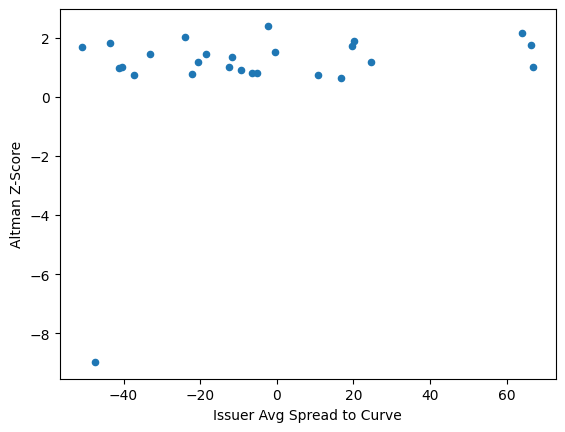

In [47]:
credit_quality_df2.plot.scatter(x='Issuer Avg Spread to Curve', y ='Altman Z-Score')

### My official recommendation would be to overweight the bonds of Skyworks Solutions Inc. (SWKS) as they offer an attractive average spread to peers and solid fundamentals. Postion can be taken as a barbell, weighted according to desired duration exposure.


In [48]:
df2[df['Ticker'] == 'SWKS']

,Ticker,Cusip,Description,Par Wtd Coupon,Maturity Date,Industry Lvl 3 Code,Industry Lvl 4 Code,Rating,OAS,Effective Duration,...,Total Return % 3-mo_LOC,Total Return % 1-mo_LOC,Spread to Worst,Yield to Maturity (s.a.),Yield to Worst (conv.),Yield to Maturity (conv.),Yield to Worst (s.a.),Effective Yield,% Mkt Value,MaturityYears
8477,SWKS,83088MAK,Skyworks Solutions Inc.,1.8,2026-06-01,Tech,Elec,BBB3,157,2.81,...,1.394,-1.255,156,5.91,5.91,5.91,5.91,5.91,0.005875,1.926027
8478,SWKS,83088MAL,Skyworks Solutions Inc.,3.0,2031-06-01,Tech,Elec,BBB3,274,6.63,...,-2.583,-6.194,274,6.58,6.58,6.58,6.58,6.57,0.005206,6.928767


In [49]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol
ticker = "SWKS"

# Get the stock information
stock = yf.Ticker(ticker)

# Get historical market data
hist = stock.history()

# Get quarterly financials
quarterly_financials = stock.quarterly_financials
quarterly_balance_sheet = stock.quarterly_balance_sheet
quarterly_cash_flow = stock.quarterly_cashflow

# Display the top of each dataframe to understand the structure
print("Quarterly Financials (Income Statement):")
print(quarterly_financials.head())

print("\nQuarterly Balance Sheet:")
print(quarterly_balance_sheet.head())

print("\nQuarterly Cash Flow:")
print(quarterly_cash_flow.head())

Quarterly Financials (Income Statement):
                                         2024-03-31   2023-12-31   2023-09-30  \
Tax Effect Of Unusual Items                 15000.0   -1312200.0 -1705.930138   
Tax Rate For Calcs                             0.05        0.081     0.005686   
Normalized EBITDA                       310500000.0  390700000.0  402100000.0   
Total Unusual Items                        300000.0  -16200000.0    -300000.0   
Total Unusual Items Excluding Goodwill     300000.0  -16200000.0    -300000.0   

                                         2023-06-30   2023-03-31 2022-12-31  
Tax Effect Of Unusual Items               -519200.0   -2402400.0        NaN  
Tax Rate For Calcs                            0.118        0.104        NaN  
Normalized EBITDA                       391400000.0  452200000.0        NaN  
Total Unusual Items                      -4400000.0  -23100000.0        NaN  
Total Unusual Items Excluding Goodwill   -4400000.0  -23100000.0        NaN  

Qua

In [50]:
# Extract relevant data
revenue = quarterly_financials.loc['Total Revenue'][:5]
net_income = quarterly_financials.loc['Net Income'][:5]
total_debt = quarterly_balance_sheet.loc['Total Debt'][:5]
interest_expense = quarterly_financials.loc['Interest Expense'][:5]
operating_income = quarterly_financials.loc['Total Operating Income As Reported'][:5]

# Calculate Interest Coverage Ratio
interest_coverage_ratio = operating_income / interest_expense

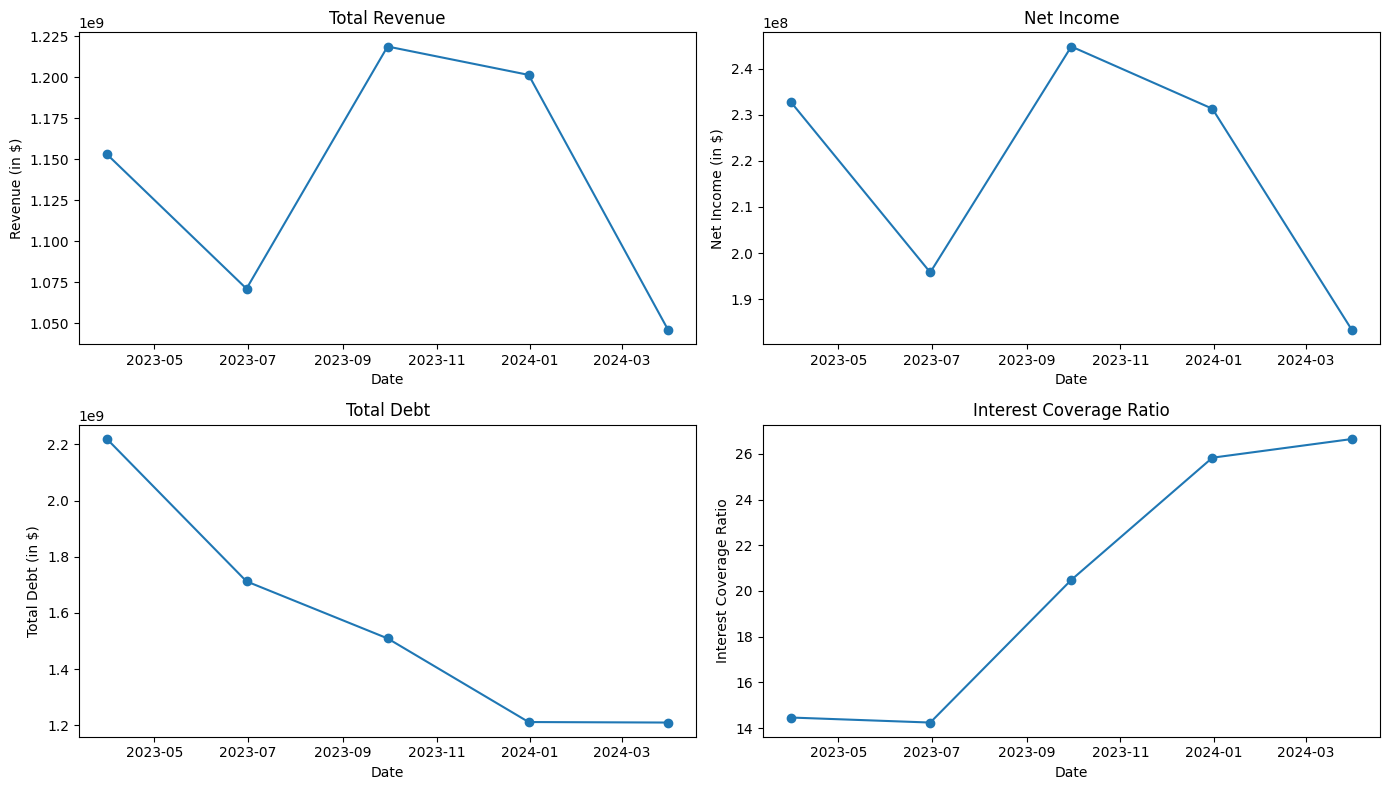

In [51]:
# Plotting the historical trend of these metrics
plt.figure(figsize=(14, 8))

# Plot Revenue
plt.subplot(2, 2, 1)
plt.plot(revenue, marker='o')
plt.title('Total Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue (in $)')

# Plot Net Income
plt.subplot(2, 2, 2)
plt.plot(net_income, marker='o')
plt.title('Net Income')
plt.xlabel('Date')
plt.ylabel('Net Income (in $)')

# Plot Total Debt
plt.subplot(2, 2, 3)
plt.plot(total_debt, marker='o')
plt.title('Total Debt')
plt.xlabel('Date')
plt.ylabel('Total Debt (in $)')

# Plot Interest Coverage Ratio
plt.subplot(2, 2, 4)
plt.plot(interest_coverage_ratio, marker='o')
plt.title('Interest Coverage Ratio')
plt.xlabel('Date')
plt.ylabel('Interest Coverage Ratio')

plt.tight_layout()
plt.show()


### It appears that SWKS is de-leveraging and has a greater capacity to meet interest payments despite the fluctuation in revenue and net income. 

### We will then drill down into a Dupont Analysis for further information

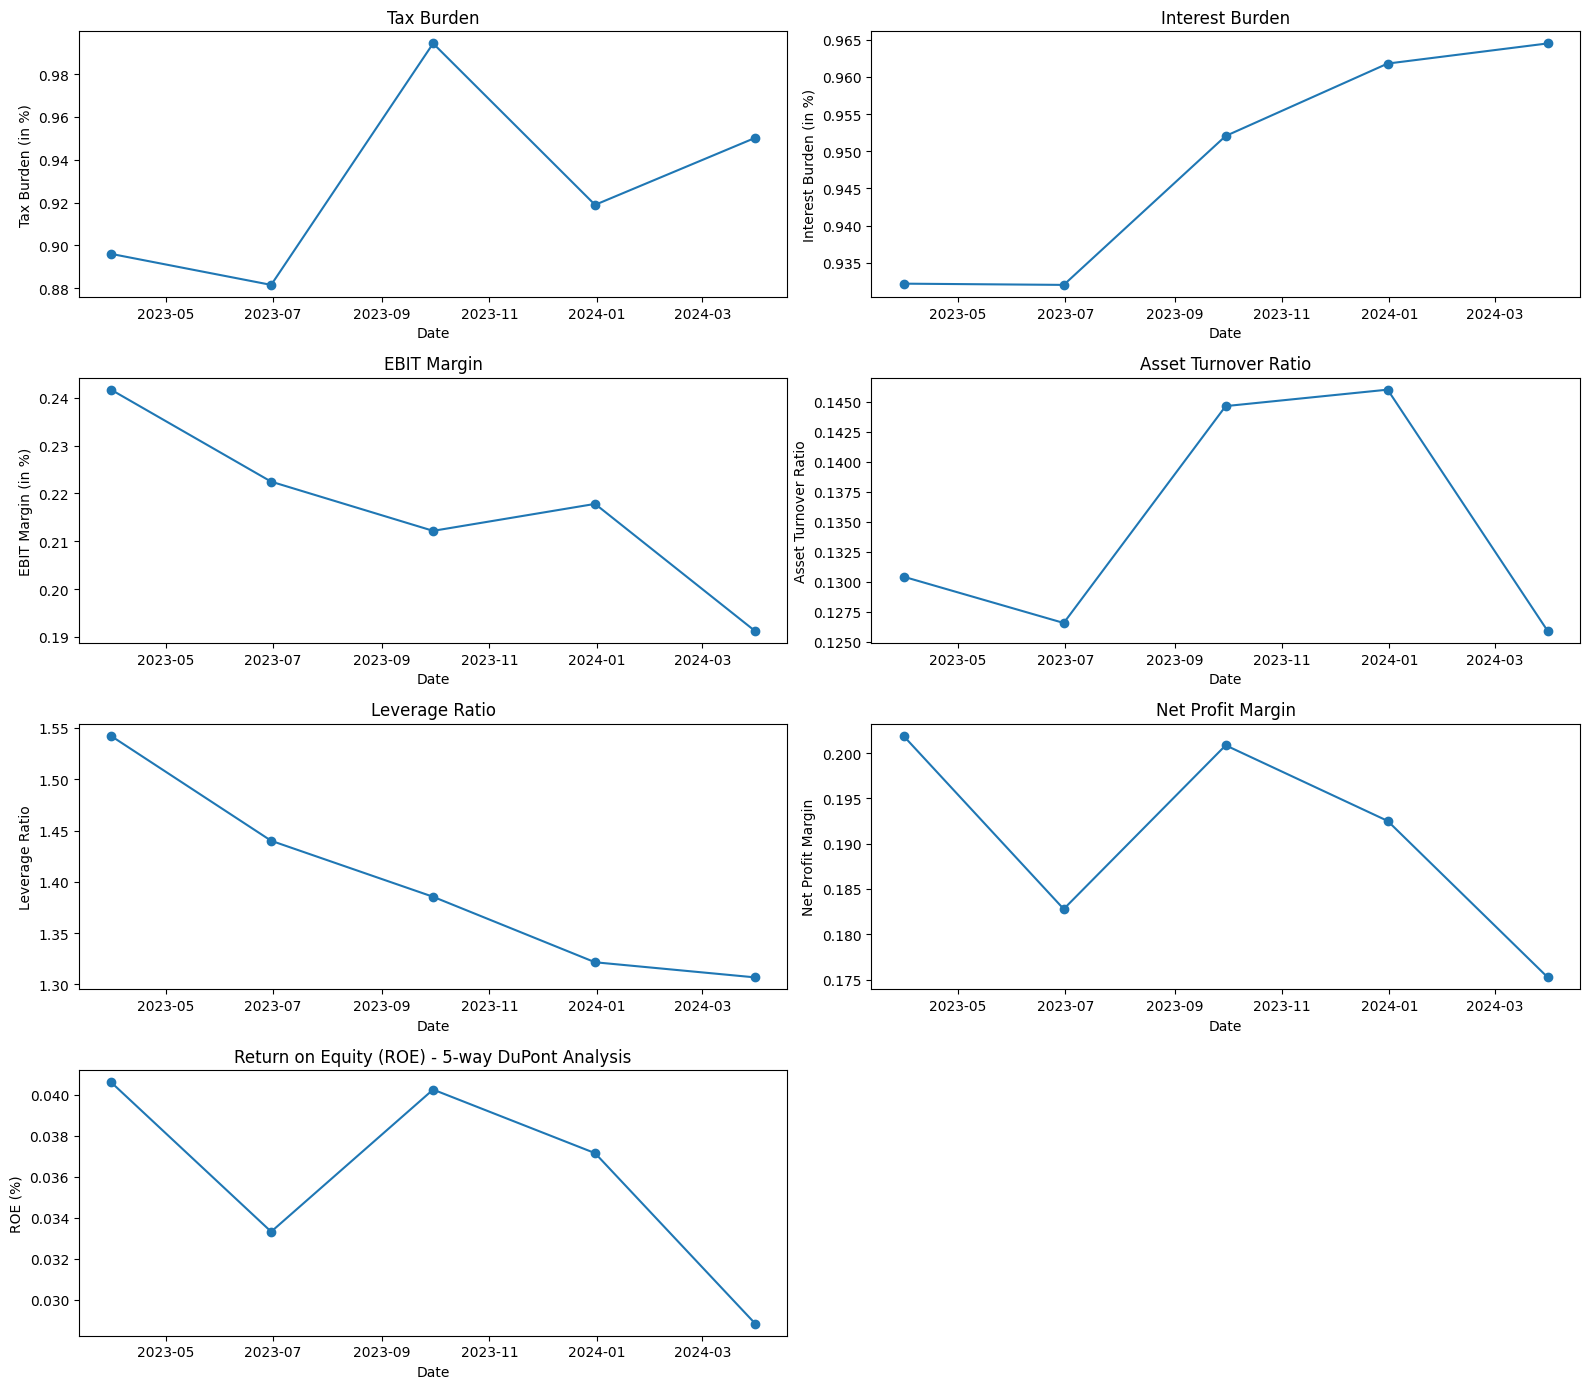

In [60]:
# Extract relevant data
revenue = quarterly_financials.loc['Total Revenue'][:5]
net_income = quarterly_financials.loc['Net Income'][:5]
total_debt = quarterly_balance_sheet.loc['Total Debt'][:5]
interest_expense = quarterly_financials.loc['Interest Expense'][:5]
operating_income = quarterly_financials.loc['EBIT'][:5]
shareholders_equity = quarterly_balance_sheet.loc['Stockholders Equity'][:5]
total_assets = quarterly_balance_sheet.loc['Total Assets'][:5]
ebit = operating_income
ebt = ebit - interest_expense

# Calculate components for 5-way DuPont analysis
tax_burden = net_income / ebt
interest_burden = ebt / ebit
ebit_margin = ebit / revenue
net_profit_margin = tax_burden * interest_burden * ebit_margin
asset_turnover = revenue / total_assets
financial_leverage = total_assets / shareholders_equity

# Calculate Return on Equity (ROE) using 5-way DuPont Analysis
roe_5way = tax_burden * interest_burden * ebit_margin * asset_turnover * financial_leverage

# Plotting the historical trend of these metrics
plt.figure(figsize=(16, 14))

# Plot tax_burden
plt.subplot(4, 2, 1)
plt.plot(tax_burden.index, tax_burden.values, marker='o')
plt.title('Tax Burden')
plt.xlabel('Date')
plt.ylabel('Tax Burden (in %)')

# Plot Interest Burden
plt.subplot(4, 2, 2)
plt.plot(interest_burden.index, interest_burden.values, marker='o')
plt.title('Interest Burden')
plt.xlabel('Date')
plt.ylabel('Interest Burden (in %)')

# Plot ebit_margin
plt.subplot(4, 2, 3)
plt.plot(ebit_margin.index, ebit_margin.values, marker='o')
plt.title('EBIT Margin')
plt.xlabel('Date')
plt.ylabel('EBIT Margin (in %)')

# Plot asset_turnover Ratio
plt.subplot(4, 2, 4)
plt.plot(asset_turnover.index, asset_turnover.values, marker='o')
plt.title('Asset Turnover Ratio')
plt.xlabel('Date')
plt.ylabel('Asset Turnover Ratio')

# Plot Leverage Ratio
plt.subplot(4, 2, 5)
plt.plot(financial_leverage.index, financial_leverage.values, marker='o')
plt.title('Leverage Ratio')
plt.xlabel('Date')
plt.ylabel('Leverage Ratio')

# Plot Net Profit Margin
plt.subplot(4, 2, 6)
plt.plot(net_profit_margin.index, net_profit_margin.values, marker='o')
plt.title('Net Profit Margin')
plt.xlabel('Date')
plt.ylabel('Net Profit Margin')

# Plot Return on Equity (ROE) using 5-way DuPont Analysis
plt.subplot(4, 2, 7)
plt.plot(roe_5way.index, roe_5way.values, marker='o')
plt.title('Return on Equity (ROE) - 5-way DuPont Analysis')
plt.xlabel('Date')
plt.ylabel('ROE (%)')

plt.tight_layout()
plt.show()

### Looking into the leverage ratio to determine the cause of the apparent deleveraging

Text(0, 0.5, 'Shareholders Equity (in $)')

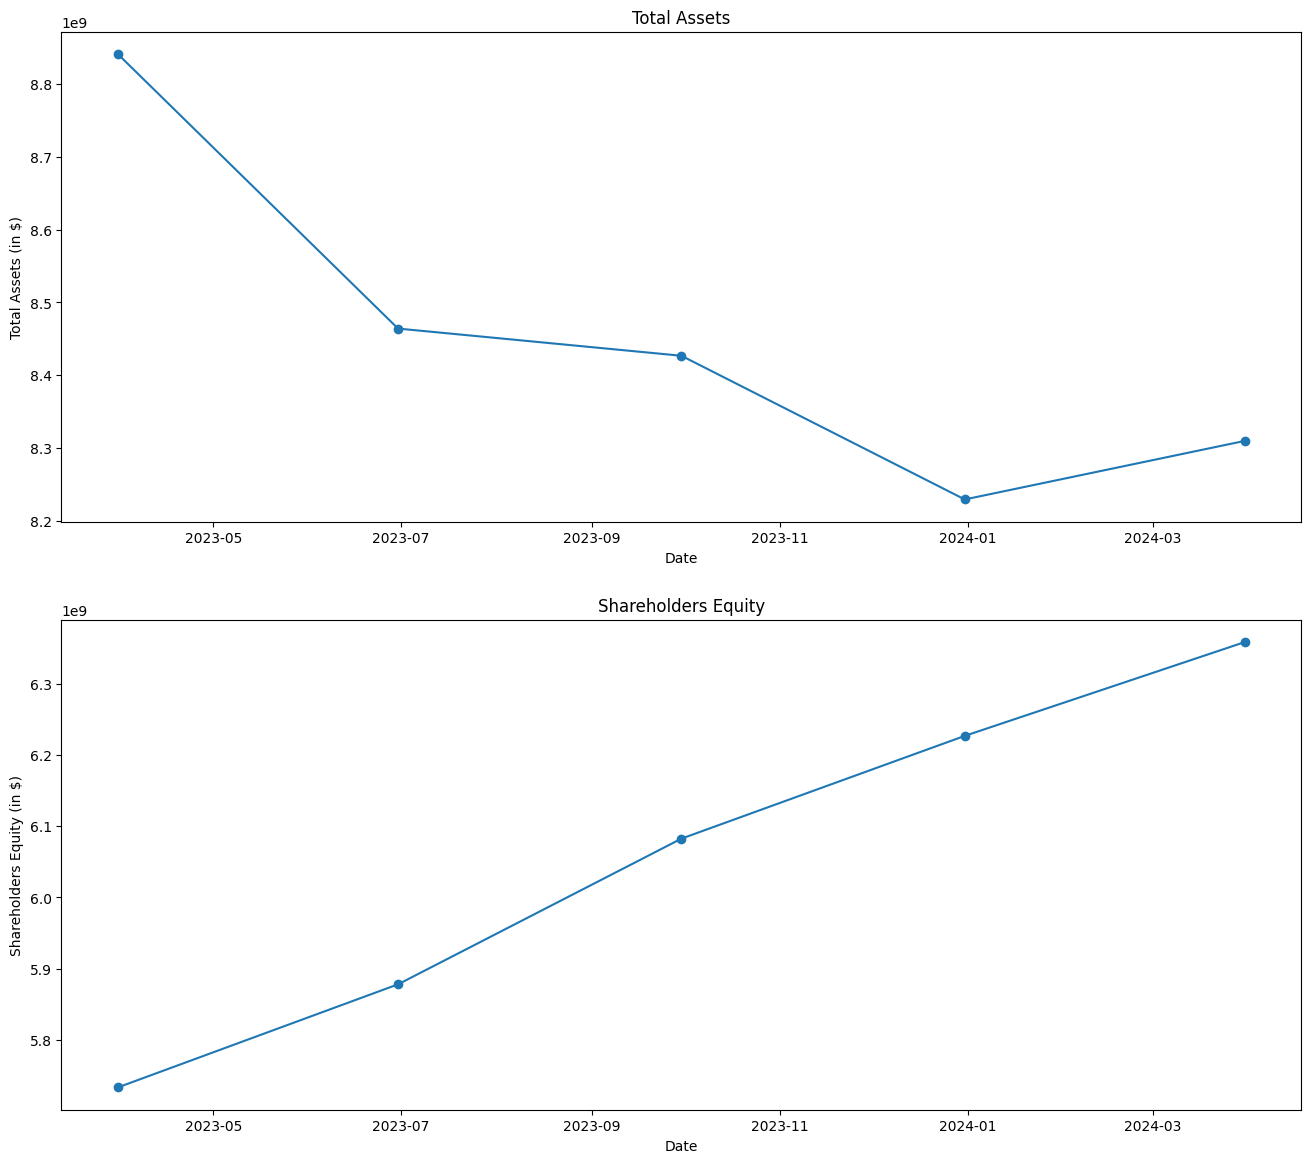

In [66]:
plt.figure(figsize=(16, 14))

# Plot Total Assets
plt.subplot(2, 1, 1)
plt.plot(total_assets.index, total_assets.values, marker='o')
plt.title('Total Assets')
plt.xlabel('Date')
plt.ylabel('Total Assets (in $)')

# Plot Interest Burden
plt.subplot(2, 1, 2)
plt.plot(shareholders_equity.index, shareholders_equity.values, marker='o')
plt.title('Shareholders Equity')
plt.xlabel('Date')
plt.ylabel('Shareholders Equity (in $)')

Text(0, 0.5, 'Retained Earnings')

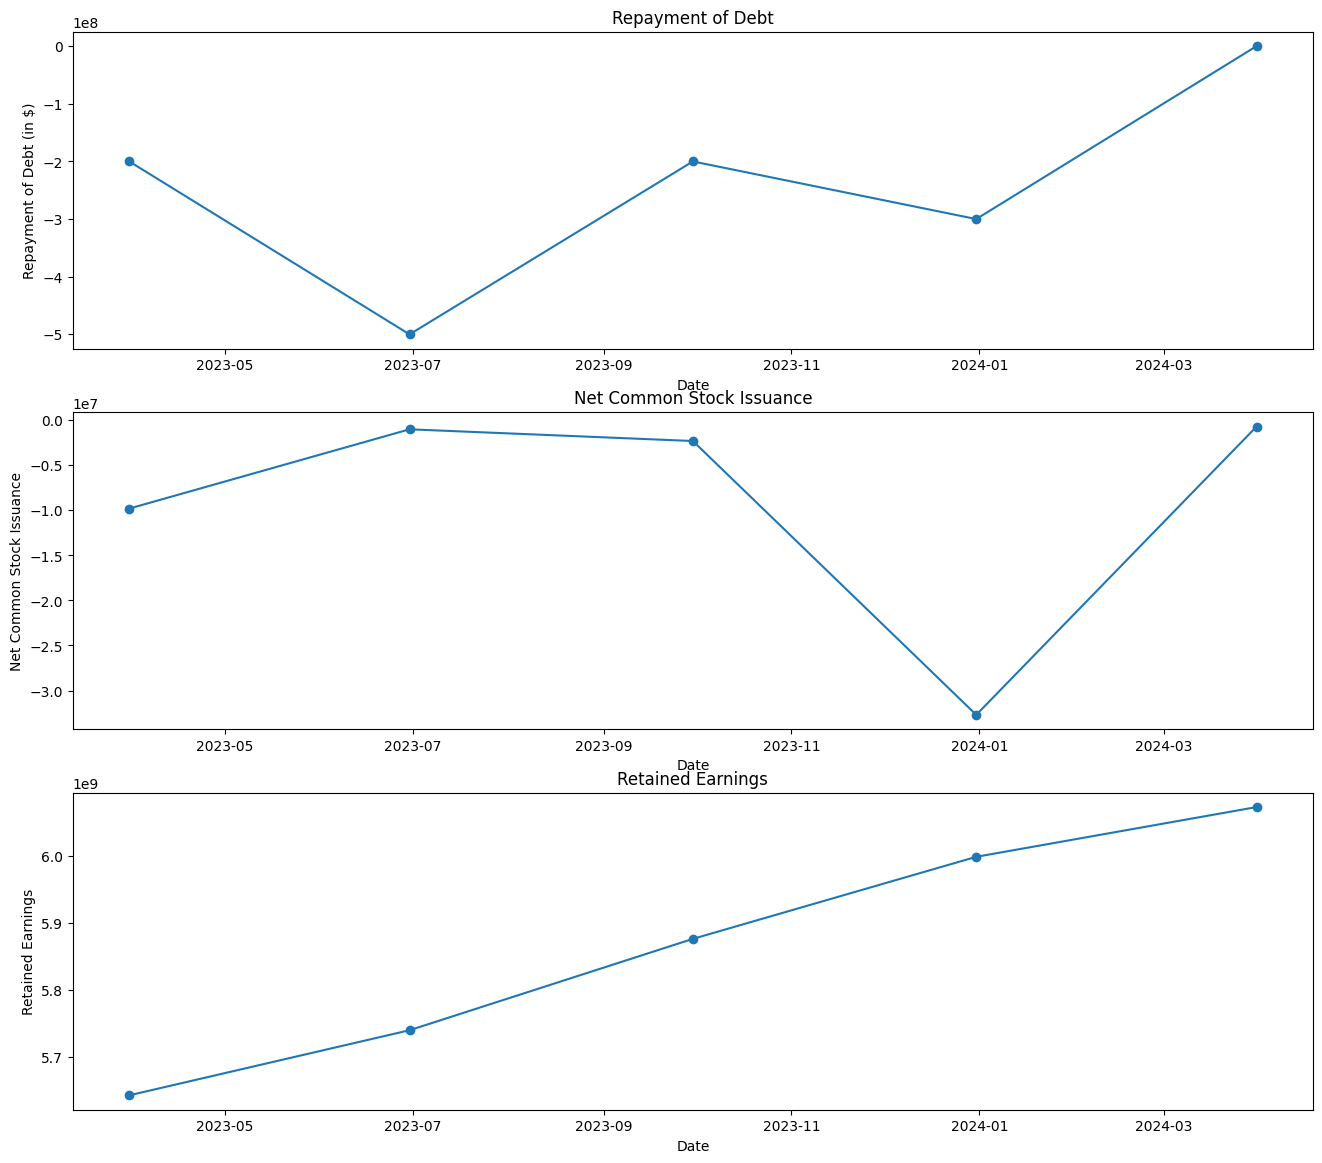

In [72]:
debt_repay = stock.quarterly_cash_flow.loc['Repayment Of Debt'][0:5]
stock_issue = stock.quarterly_cash_flow.loc['Net Common Stock Issuance'][0:5]
retained_earnings = stock.quarterly_balance_sheet.loc['Retained Earnings'][0:5]

plt.figure(figsize=(16, 14))

# Plot Repayment of Debt
plt.subplot(3, 1, 1)
plt.plot(debt_repay.index, debt_repay.values, marker='o')
plt.title('Repayment of Debt')
plt.xlabel('Date')
plt.ylabel('Repayment of Debt (in $)')

# Plot Net Common Stock Issuance
plt.subplot(3, 1, 2)
plt.plot(stock_issue.index, stock_issue.values, marker='o')
plt.title('Net Common Stock Issuance')
plt.xlabel('Date')
plt.ylabel('Net Common Stock Issuance')

# Plot Retained Earnings
plt.subplot(3, 1, 3)
plt.plot(retained_earnings.index, retained_earnings.values, marker='o')
plt.title('Retained Earnings')
plt.xlabel('Date')
plt.ylabel('Retained Earnings')

### It appears that Skyworks is paying down debt and repurchasing stock (albeit at a slower rate) via retained earnings